  0%|                                                   | 0/100 [00:00<?, ?it/s]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


/var/folders/ym/bb0m3ykn0n7dm__gm7m9f9y80000gn/T/ipykernel_9843/710817455.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  QFI[ii]      = diff.transpose().conj().dot(diff) - abs(psit[:,ii].transpose().conj().dot(diff))
  1%|▍                                        | 1/100 [00:38<1:04:17, 38.97s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


  2%|▊                                        | 2/100 [01:18<1:04:23, 39.42s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


  3%|█▏                                       | 3/100 [01:57<1:03:36, 39.35s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


  4%|█▋                                       | 4/100 [02:38<1:03:34, 39.73s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


  5%|██                                       | 5/100 [03:18<1:03:17, 39.97s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


  6%|██▍                                      | 6/100 [03:58<1:02:45, 40.06s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


  7%|██▊                                      | 7/100 [04:39<1:02:19, 40.21s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


  8%|███▎                                     | 8/100 [05:22<1:02:49, 40.97s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


  9%|███▋                                     | 9/100 [06:02<1:01:54, 40.82s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 10%|████                                    | 10/100 [06:43<1:01:05, 40.72s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 11%|████▍                                   | 11/100 [07:23<1:00:04, 40.50s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 12%|█████                                     | 12/100 [08:04<59:40, 40.68s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 13%|█████▍                                    | 13/100 [08:44<58:58, 40.67s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 14%|█████▉                                    | 14/100 [09:25<58:15, 40.64s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 15%|██████▎                                   | 15/100 [10:05<57:21, 40.49s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 16%|██████▍                                 | 16/100 [11:07<1:05:56, 47.10s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 17%|██████▊                                 | 17/100 [11:56<1:05:36, 47.43s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 18%|███████▏                                | 18/100 [12:36<1:01:59, 45.36s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 19%|███████▉                                  | 19/100 [13:16<59:09, 43.82s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 20%|████████▍                                 | 20/100 [13:58<57:29, 43.12s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 21%|████████▊                                 | 21/100 [14:39<55:47, 42.37s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 22%|█████████▏                                | 22/100 [15:20<54:53, 42.22s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 23%|█████████▋                                | 23/100 [16:01<53:38, 41.80s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 24%|██████████                                | 24/100 [16:42<52:44, 41.63s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 25%|██████████▌                               | 25/100 [17:23<51:42, 41.37s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 26%|██████████▉                               | 26/100 [18:04<50:51, 41.24s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 27%|███████████▎                              | 27/100 [18:45<50:07, 41.20s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 28%|███████████▊                              | 28/100 [19:26<49:19, 41.11s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 29%|████████████▏                             | 29/100 [20:09<49:07, 41.52s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 30%|████████████▌                             | 30/100 [20:51<48:54, 41.93s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 31%|█████████████                             | 31/100 [21:34<48:29, 42.17s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 32%|█████████████▍                            | 32/100 [22:17<47:56, 42.31s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 33%|█████████████▊                            | 33/100 [22:59<47:18, 42.37s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 34%|██████████████▎                           | 34/100 [23:42<46:40, 42.43s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 35%|█████████████▋                         | 35/100 [40:35<6:01:25, 333.63s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 36%|██████████████                         | 36/100 [57:39<9:36:46, 540.72s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 37%|██████████████▍                        | 37/100 [58:42<6:57:16, 397.40s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 38%|█████████████▋                      | 38/100 [1:31:55<15:05:22, 876.17s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 39%|██████████████                      | 39/100 [1:48:35<15:28:21, 913.13s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 40%|██████████████▍                     | 40/100 [1:50:02<11:05:31, 665.53s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 41%|███████████████▏                     | 41/100 [1:51:24<8:02:16, 490.46s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 42%|███████████████▌                     | 42/100 [1:52:47<5:55:57, 368.23s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 43%|███████████████▉                     | 43/100 [1:54:11<4:28:41, 282.84s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 44%|████████████████▎                    | 44/100 [1:55:35<3:28:14, 223.12s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 45%|████████████████▋                    | 45/100 [1:57:00<2:46:28, 181.61s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 46%|█████████████████                    | 46/100 [1:58:25<2:17:29, 152.76s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 47%|█████████████████▍                   | 47/100 [1:59:51<1:57:17, 132.78s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 48%|█████████████████▊                   | 48/100 [2:01:19<1:43:23, 119.29s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 49%|██████████████████▏                  | 49/100 [2:02:45<1:32:53, 109.28s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 50%|██████████████████▌                  | 50/100 [2:04:11<1:25:19, 102.39s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 51%|███████████████████▍                  | 51/100 [2:05:38<1:19:42, 97.61s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 52%|███████████████████▊                  | 52/100 [2:07:05<1:15:32, 94.42s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 53%|████████████████████▏                 | 53/100 [2:08:30<1:11:51, 91.73s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 54%|████████████████████▌                 | 54/100 [2:09:57<1:09:08, 90.19s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 55%|████████████████████▉                 | 55/100 [2:11:21<1:06:20, 88.45s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 56%|█████████████████████▎                | 56/100 [2:12:40<1:02:52, 85.75s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 57%|██████████████████████▊                 | 57/100 [2:13:55<59:03, 82.42s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 58%|███████████████████████▏                | 58/100 [2:15:04<54:46, 78.25s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 59%|███████████████████████▌                | 59/100 [2:16:13<51:32, 75.43s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 60%|██████████████████████▏              | 60/100 [2:22:31<1:50:48, 166.21s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 61%|██████████████████████▌              | 61/100 [2:23:37<1:28:38, 136.38s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 62%|██████████████████████▉              | 62/100 [2:24:48<1:13:52, 116.65s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 63%|███████████████████████▎             | 63/100 [2:26:01<1:03:56, 103.70s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 64%|█████████████████████████▌              | 64/100 [2:27:14<56:36, 94.36s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 65%|██████████████████████████              | 65/100 [2:28:25<51:02, 87.51s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 66%|██████████████████████████▍             | 66/100 [2:29:35<46:29, 82.03s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 67%|██████████████████████████▊             | 67/100 [2:30:44<42:55, 78.06s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 68%|███████████████████████████▏            | 68/100 [2:31:56<40:41, 76.29s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 69%|███████████████████████████▌            | 69/100 [2:33:07<38:37, 74.75s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 70%|████████████████████████████            | 70/100 [2:34:17<36:40, 73.34s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 71%|████████████████████████████▍           | 71/100 [2:35:28<35:03, 72.54s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 72%|████████████████████████████▊           | 72/100 [2:36:38<33:29, 71.76s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 73%|█████████████████████████████▏          | 73/100 [2:37:48<32:08, 71.43s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 74%|█████████████████████████████▌          | 74/100 [2:38:59<30:50, 71.18s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 75%|██████████████████████████████          | 75/100 [2:40:09<29:34, 70.98s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 76%|██████████████████████████████▍         | 76/100 [2:41:20<28:24, 71.04s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 77%|██████████████████████████████▊         | 77/100 [2:42:31<27:11, 70.96s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 78%|███████████████████████████████▏        | 78/100 [2:43:42<25:58, 70.82s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 79%|███████████████████████████████▌        | 79/100 [2:44:54<24:53, 71.12s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 80%|███████████████████████████████▏       | 80/100 [2:48:48<39:59, 119.99s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 81%|███████████████████████████████▌       | 81/100 [2:50:01<33:32, 105.91s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 82%|████████████████████████████████▊       | 82/100 [2:51:09<28:22, 94.59s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 83%|█████████████████████████████████▏      | 83/100 [2:52:19<24:43, 87.28s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 84%|█████████████████████████████████▌      | 84/100 [2:53:29<21:53, 82.06s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 85%|██████████████████████████████████      | 85/100 [2:54:39<19:37, 78.53s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 86%|██████████████████████████████████▍     | 86/100 [2:55:49<17:44, 76.02s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 87%|██████████████████████████████████▊     | 87/100 [2:57:00<16:06, 74.32s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 88%|███████████████████████████████████▏    | 88/100 [2:58:12<14:43, 73.59s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 89%|███████████████████████████████████▌    | 89/100 [3:00:11<16:01, 87.40s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 90%|█████████████████████████████████▎   | 90/100 [3:17:09<1:01:04, 366.44s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 91%|███████████████████████████████████▍   | 91/100 [3:22:56<54:07, 360.79s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 92%|███████████████████████████████████▉   | 92/100 [3:24:04<36:22, 272.87s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 93%|████████████████████████████████████▎  | 93/100 [3:25:10<24:34, 210.69s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 94%|████████████████████████████████████▋  | 94/100 [3:26:16<16:43, 167.30s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 95%|█████████████████████████████████████  | 95/100 [3:27:25<11:28, 137.77s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 96%|█████████████████████████████████████▍ | 96/100 [3:28:32<07:46, 116.70s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 97%|█████████████████████████████████████▊ | 97/100 [3:29:41<05:07, 102.39s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 98%|███████████████████████████████████████▏| 98/100 [3:30:50<03:04, 92.41s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


 99%|███████████████████████████████████████▌| 99/100 [3:32:00<01:25, 85.54s/it]

0.025
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


100%|██████████████████████████████████████| 100/100 [3:33:09<00:00, 127.89s/it]


NameError: name 'MultipleLocator' is not defined

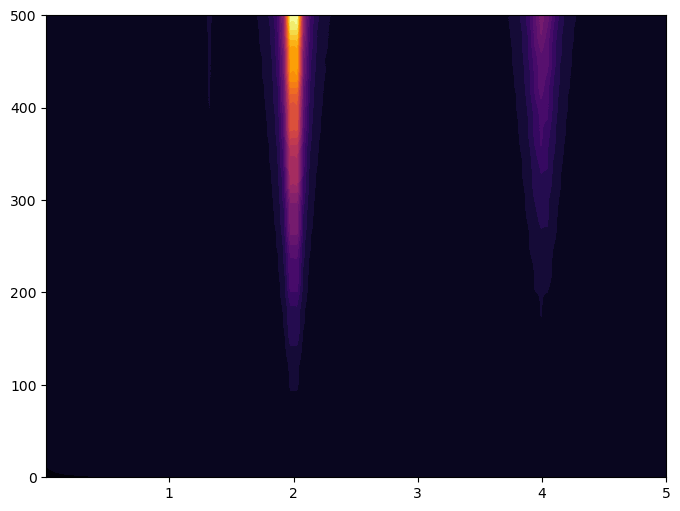

In [1]:
import sys,os
import scipy.io as spio
import numpy as np
from quspin.tools.measurements import obs_vs_time
import pickle
from quspin.operators import hamiltonian
from quspin.operators import quantum_LinearOperator
from quspin.basis import boson_basis_1d # bosonic Hilbert space 
import time
import matplotlib.pyplot as plt # plotting library
from quspin.tools.Floquet import Floquet_t_vec # stroboscopic time vector

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d, spinless_fermion_basis_1d # Hilbert spacespin basis
import numpy as np # generic math functions
import matplotlib.pyplot as plt # plotting library
from quspin.tools.measurements import ent_entropy, diag_ensemble # entropies
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
from matplotlib import ticker, cm 
import tqdm

def parallel_QFI(Omega,L,Nsteps,t):
    import numpy as np
    
    dw = Omega / 1e+6
    L=L # system size
    h=1. # z magnetic field strength
    J=0.1 * h # spin xx interaction
    g=0
    scale = 1/h
    "time_evolution until 100 period"
    #tf = 5.
    Nsteps = Nsteps
    t=t
    #t=scale * np.linspace(0,tf,Nsteps)
    dt = tf/Nsteps
    print(dt*scale)

    H,psi_i= H_Ising(Omega,L,h,g,J)
    Hp,psi_i = H_Ising(Omega+dw,L,h,g,J)
    Hm,psi_i = H_Ising(Omega-dw,L,h,g,J)
    H2p,psi_i = H_Ising(Omega+2*dw,L,h,g,J)
    H2m,psi_i = H_Ising(Omega-2*dw,L,h,g,J)

    psit=H.evolve(psi_i,0,t)
    psitp=Hp.evolve(psi_i,0,t)
    psitm=Hm.evolve(psi_i,0,t)
    psit2p=H2p.evolve(psi_i,0,t)
    psit2m=H2p.evolve(psi_i,0,t)
    
    QFI = np.zeros(Nsteps)
    for ii in range(Nsteps):
        diff     = (-psit2p[:,ii] + 8*psitp[:,ii] - 8*psitm[:,ii] + psit2m[:,ii]) / (12 * dw)

        QFI[ii]      = diff.transpose().conj().dot(diff) - abs(psit[:,ii].transpose().conj().dot(diff))
    
    #print(np.real(QFI))  
    return np.real(QFI)




def H_Ising(Omega,L,h,g,J):
    
    import numpy as np
    
    def drive1(t,Omega):
        return np.cos(2.*Omega*t)
    drive1_args=[Omega]
    
    def drive2(t,Omega):
        return np.cos(Omega*t)
    drive2_args=[Omega]
    

    "define site-coupling lists for operators"
    x_field=[[g,i] for i in range(L)]
    z_field=[[h,i] for i in range(L)]
    z_field2 = []
    for ii in range(L):
        if ii== L-1:
            z_field2.append([h,ii])
        else:
            z_field2.append([h,ii])
            
    J_nn = []
    for ii in range(L-1):
        J_nn.append([J,ii,ii+1])
    "Floquet DD"
    J_nn1 = []
    for ii in range(L-1):
        if ii%2==0:
            J_nn1.append([J,ii,ii+1])
        else:
            J_nn1.append([0.,ii,ii+1])
    J_nn2 = []
    for ii in range(L-1):
        if ii%2==1:
            J_nn2.append([J,ii,ii+1])
        else:
            J_nn2.append([0.,ii,ii+1])


    dynamic1=[["xx",J_nn1,drive1,drive1_args],["xx",J_nn2,drive2,drive2_args]]
  
    dynamic2 = []

    # static and dynamic lists
    static=[["x",x_field],["z",z_field]]

    static2=[["x",x_field],["z",z_field2],["xx",J_nn]]
  

    "construct spin basis"
    basis= spin_basis_1d(L=L,S='1/2',pauli=-1)    
    ###### construct Hamiltonian
    H=hamiltonian(static,dynamic1,dtype=np.float64,basis=basis)
    H2=hamiltonian(static2,dynamic2,dtype=np.float64,basis=basis)


    "Ground State of H2" 
    E,V=H2.eigsh(time=0.0,k=1,which='SA')
    psi_i=V[:,0]
    
    return H, psi_i


N=3
Nvec = 100
h=1.
w_vec = h* np.linspace(1e-2, 5, Nvec)
tf = 500.
Nsteps = 20000
t=np.linspace(0,tf,Nsteps)
QFI = np.zeros((Nsteps,Nvec))

for zz in tqdm.tqdm(range(Nvec)):
       QFI[:,zz] = parallel_QFI(w_vec[zz],N,Nsteps,t)

results = [w_vec, t, QFI]
with open("QFI-QuSpinL3.pickle",'wb') as handle:
    pickle.dump(results, handle) 


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
#"3D plot auto-correlation"
X, Y = np.meshgrid(w_vec,t)


cp = plt.contourf(X,Y,QFI,levels=30,cmap=cm.inferno)
    # plt.text(3., 45, r'(d)',{'color': 'black', 'fontsize': 40, 'ha': 'center', 'va': 'center'}, style='normal')

ax.xaxis.set_major_locator(MultipleLocator(1.0))
#ax.xaxis.set_minor_locator(MultipleLocator(1.0))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(50))
#ax.tick_params(which='both', width=1.0,direction='out', top='off',right='off')
ax.tick_params(which='major', width=1.0, length=10,direction='out')
ax.tick_params(which='minor', length=8, color='k',direction='out')


plt.ylabel('$t/T$')
plt.xlabel('Bond')
plt.colorbar().set_label(r'Concurrence')
plt.savefig("QFI.png", format="png")
plt.show()

#plt.figure(figsize=(6,4))
#X, Y = np.meshgrid(w_vec,t)
#Z = QFI
#cs = plt.contourf(X, Y, Z,levels=30, 
 #                 locator = ticker.LogLocator(), 
 #                 cmap ="viridis") 
  
#cbar = plt.colorbar(cs) 
  
#plt.title('matplotlib.pyplot.contourf() Example') 
#plt.show() 

plt.figure(figsize=(6,4))
plt.plot(w_vec,QFI[:,199],'o-',       label = "L = " + str(N))
plt.legend()
plt.ylabel("Quantum Fisher Information")
plt.xlabel(r"$J_2$")

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()




In [32]:
import multiprocessing

print("Number of cpu : ", multiprocessing.cpu_count())

400000/4

Number of cpu :  16


100000.0